In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio

* They only have 10 promotions.
* The rewards are 0, 2, 3, 5 and 10 USD off?
* To complete an offer you have to spend from 0 up to 20 USD.
* An offer can last 3, 4 ,5 ,7 or 10 days.
* Offers might be dicsounts and bogo or informational

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [263]:
def clean_portfolio(df):
    '''
    This funtions cleans the channels of the portfolio
    '''
    # Break channels into separate columns
    df_channels = df.channels.apply( pd.Series )
    df_channels.columns = ['ch1', 'ch2', 'ch3', 'ch4']
    # Clean channel columns in long format
    df_channels_long = (
    pd.concat([portfolio, df_channels], axis = 1)
     .loc[: , ['id', 'ch1', 'ch2', 'ch3', 'ch4']]
     .melt( id_vars='id')
     .rename( columns = {'value' : 'channel'} )
    )
    # Filter non existen channels by promotion
    df_channels_long_filtered = (
        df_channels_long
            .loc[pd.notna( df_channels_long.channel ), ['id', 'channel']]
            .assign(val = 1))
    # Return clean channels to wide format
    df_channels_clean = (
    df_channels_long_filtered
        .pivot(index = 'id', columns = 'channel')
        .fillna(0)
    )
    df_channels_clean.columns = df_channels_clean.columns.droplevel(0)
    df_channels_clean.reset_index()
    # Join clean channels to portoflio
    df_cleaned = df.join(df_channels_clean, on = ['id'])
    df_cleaned = df_cleaned.rename( columns = {'email': 'ch_email', 'mobile' : 'ch_mobile', 'social' : 'ch_social', 'web' : 'ch_web'})
    df_cleaned = df_cleaned.drop( ['channels'] , axis = 1)
    return( df_cleaned )
clean_portfolio( portfolio )

,difficulty,duration,id,offer_type,reward,ch_email,ch_mobile,ch_social,ch_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1.0,1.0,1.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1.0,1.0,1.0,1.0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1.0,1.0,0.0,1.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1.0,1.0,0.0,1.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1.0,0.0,0.0,1.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1.0,1.0,1.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1.0,1.0,1.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1.0,1.0,1.0,0.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1.0,1.0,1.0,1.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1.0,1.0,0.0,1.0


In [3]:
portfolio.shape

(10, 6)

In [4]:

np.sort( portfolio.reward.unique() )


array([ 0,  2,  3,  5, 10])

In [5]:
np.sort( portfolio.difficulty.unique() )

array([ 0,  5,  7, 10, 20])

In [6]:
np.sort( portfolio.duration.unique() )

array([ 3,  4,  5,  7, 10])

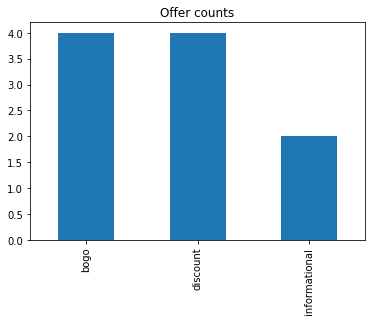

In [7]:
portfolio['offer_type'].value_counts().plot(kind = 'bar', title = 'Offer counts', y = 'Counts');

## Profile

In [8]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


En género:
- ¿Qué es None y qué es 0?

In [9]:
profile.gender.unique()

array([None, u'F', u'M', u'O'], dtype=object)

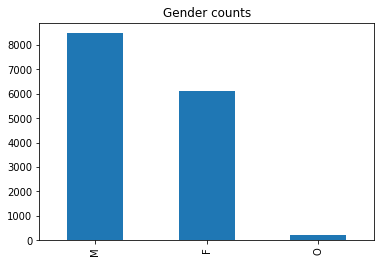

In [10]:
profile['gender'].value_counts().plot(kind = 'bar', title = 'Gender counts', y = 'Counts');

En age:
* tenemos valores muy extremos en la edad
* son mayores de edad
* para limpiar la edad podría crear grupos de edad

In [11]:
np.sort( profile.age.unique() )

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 118])

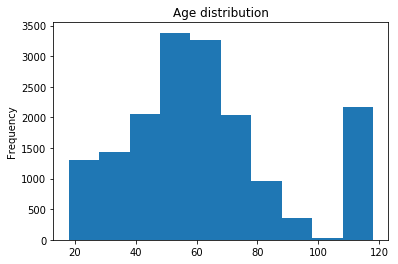

In [12]:
profile['age'].plot(kind = 'hist', bins=10, grid = False, title = "Age distribution");


Became member on:
* La fecha hay que formatearla y parsearla como fecha. YYYYMMDD


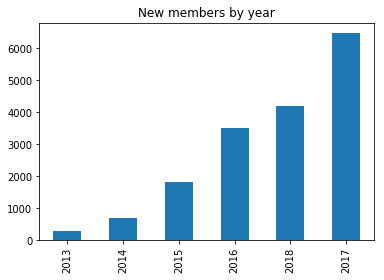

In [13]:
member_year = profile['became_member_on'].astype('str').str.slice( start = 0, stop= 4)
member_month = profile['became_member_on'].astype('str').str.slice( start = 4, stop= 6)
member_day = profile['became_member_on'].astype('str').str.slice( start = 6, stop= 8)
profile['clean_became_member_on'] = pd.to_datetime( member_year + "-" + member_month + "-" + member_day )

member_year.value_counts().sort_values().plot(kind = 'bar', title = "New members by year");

Income:
* Tiene valores nulos
* Supongo que el ingreso está estimado en USD

False    14825
True      2175
Name: income, dtype: int64

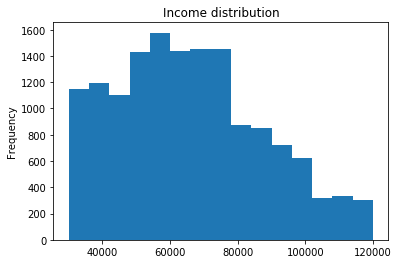

In [14]:
profile['income'].plot(kind = 'hist', bins=15, grid = False, title = "Income distribution");

profile.income.describe()

profile.income.isna().value_counts()

## Transcript

* Join transcript and profile with person and id respectively.
* Join transcript with portfolio with value offer id and id, respectively.
* The column value stores in a dictionary offer_id and amount.

Events:
* Transactions
* Offer received
* Offer viewed
* Offer completed

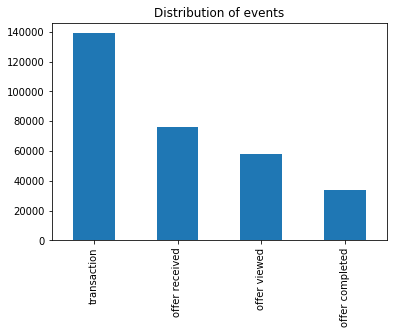

In [15]:
transcript.event.value_counts().plot( kind = 'bar', title = "Distribution of events");

Time

In [16]:
print( "Max days since beginning of test: {}".format(700 / 24) )

Max days since beginning of test: 29


Value:
    
* Cuando event es transacción viene el amount de la transacción la oferta.
* Pero la offer completed puede tener offer completed no tiene amount.

In [17]:
transcript.sample(20)

,event,person,time,value
187979,transaction,7f27070d07eb44cb89b9a547074ca343,456,{u'amount': 16.71}
47390,transaction,d10238bffa114193b35f0e4291aef010,126,{u'amount': 23.61}
123589,transaction,041fd7c6b796430a867c4e03d2ff8f4d,336,{u'amount': 1.61}
11770,offer received,7bc77922ea884ca0a795810918b2e833,0,{u'offer id': u'3f207df678b143eea3cee63160fa8b...
226762,offer completed,900e1382081b49b6ac7512fc02775d0f,522,{u'offer_id': u'2906b810c7d4411798c6938adc9daa...
96662,transaction,d12f8c848c854a9ebf3443457e172e01,258,{u'amount': 7.06}
264143,offer viewed,03e67807671e4cb4bb34f2ebabc97d28,582,{u'offer id': u'f19421c1d4aa40978ebb69ca19b0e2...
157518,offer received,073e3ef64e344bc8891732b558582492,408,{u'offer id': u'2298d6c36e964ae4a3e7e9706d1fb8...
146533,offer completed,b8c5cacabf4d42ea8fd403bb3a7b7706,390,{u'offer_id': u'2906b810c7d4411798c6938adc9daa...
187000,transaction,6573f79f3cbc499baafe7e3093640fc3,450,{u'amount': 29.52}


In [18]:
transcript[ transcript.person == '7f0f4f70ce834918828bd074dfa41e85' ]

,event,person,time,value
6237,offer received,7f0f4f70ce834918828bd074dfa41e85,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
59446,offer received,7f0f4f70ce834918828bd074dfa41e85,168,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
67608,offer viewed,7f0f4f70ce834918828bd074dfa41e85,168,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
73514,transaction,7f0f4f70ce834918828bd074dfa41e85,180,{u'amount': 4.26}
88016,transaction,7f0f4f70ce834918828bd074dfa41e85,222,{u'amount': 0.7}
89744,transaction,7f0f4f70ce834918828bd074dfa41e85,228,{u'amount': 10.21}
89745,offer completed,7f0f4f70ce834918828bd074dfa41e85,228,{u'offer_id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
91354,transaction,7f0f4f70ce834918828bd074dfa41e85,234,{u'amount': 12.09}
97040,transaction,7f0f4f70ce834918828bd074dfa41e85,258,{u'amount': 1.01}
102037,transaction,7f0f4f70ce834918828bd074dfa41e85,282,{u'amount': 4.72}


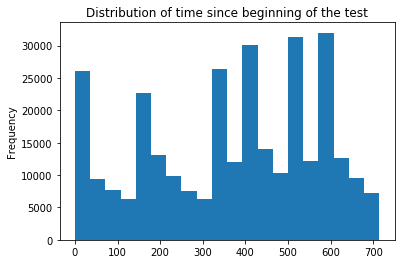

In [19]:
transcript.time.plot(kind = 'hist', bins = 20, title = "Distribution of time since beginning of the test");

In [20]:
df_sample = transcript[ transcript.person == '7f0f4f70ce834918828bd074dfa41e85' ].copy()
df_sample

,event,person,time,value
6237,offer received,7f0f4f70ce834918828bd074dfa41e85,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
59446,offer received,7f0f4f70ce834918828bd074dfa41e85,168,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
67608,offer viewed,7f0f4f70ce834918828bd074dfa41e85,168,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
73514,transaction,7f0f4f70ce834918828bd074dfa41e85,180,{u'amount': 4.26}
88016,transaction,7f0f4f70ce834918828bd074dfa41e85,222,{u'amount': 0.7}
89744,transaction,7f0f4f70ce834918828bd074dfa41e85,228,{u'amount': 10.21}
89745,offer completed,7f0f4f70ce834918828bd074dfa41e85,228,{u'offer_id': u'4d5c57ea9a6940dd891ad53e9dbe8d...
91354,transaction,7f0f4f70ce834918828bd074dfa41e85,234,{u'amount': 12.09}
97040,transaction,7f0f4f70ce834918828bd074dfa41e85,258,{u'amount': 1.01}
102037,transaction,7f0f4f70ce834918828bd074dfa41e85,282,{u'amount': 4.72}


In [24]:
df_sample.shape

(16, 4)

In [89]:
def clean_transcript( df ):
    '''
    This function cleans de offer id dataset. It breaks value in separate values for offer id, amount and reward.
    '''
    df_clean = pd.concat([df, df['value'].apply(pd.Series)], axis = 1)
    df_clean['offer_id_clean'] = [row[5] if not pd.isna( row[5]) else row[7] for row in df_clean.itertuples()]
    df_clean = df_clean.drop( columns = ['offer id', 'offer_id'])
    df_clean = df_clean.rename( columns = {'offer_id_clean': 'offer_id'} )
    df_clean = df_clean[['event', 'person', 'time', 'offer_id', 'amount', 'reward']]
    return( df_clean )

clean_transcript( df_sample)

,event,person,time,offer_id,amount,reward
6237,offer received,7f0f4f70ce834918828bd074dfa41e85,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
59446,offer received,7f0f4f70ce834918828bd074dfa41e85,168,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
67608,offer viewed,7f0f4f70ce834918828bd074dfa41e85,168,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
73514,transaction,7f0f4f70ce834918828bd074dfa41e85,180,NaN,4.26,NaN
88016,transaction,7f0f4f70ce834918828bd074dfa41e85,222,NaN,0.70,NaN
89744,transaction,7f0f4f70ce834918828bd074dfa41e85,228,NaN,10.21,NaN
89745,offer completed,7f0f4f70ce834918828bd074dfa41e85,228,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0
91354,transaction,7f0f4f70ce834918828bd074dfa41e85,234,NaN,12.09,NaN
97040,transaction,7f0f4f70ce834918828bd074dfa41e85,258,NaN,1.01,NaN
102037,transaction,7f0f4f70ce834918828bd074dfa41e85,282,NaN,4.72,NaN


In [95]:
#%%time
#transcript_cleaned = clean_offer_id( transcript )
#transcript_cleaned.to_csv("data/transcript_cleaned.csv", index = False )

CPU times: user 3min 26s, sys: 591 ms, total: 3min 26s
Wall time: 3min 26s


In [97]:
transcript = pd.read_csv("data/transcript_cleaned.csv")

transcript

### A user story

In [114]:
client_id = '7f0f4f70ce834918828bd074dfa41e85'

In [115]:
profile[ profile.id == client_id]

,age,became_member_on,gender,id,income,clean_became_member_on
8537,54,20130906,M,7f0f4f70ce834918828bd074dfa41e85,38000.0,2013-09-06


In [122]:
transcript[ transcript.person == client_id]

,event,person,time,offer_id,amount,reward
6237,offer received,7f0f4f70ce834918828bd074dfa41e85,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
59446,offer received,7f0f4f70ce834918828bd074dfa41e85,168,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
67608,offer viewed,7f0f4f70ce834918828bd074dfa41e85,168,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
73514,transaction,7f0f4f70ce834918828bd074dfa41e85,180,NaN,4.26,NaN
88016,transaction,7f0f4f70ce834918828bd074dfa41e85,222,NaN,0.70,NaN
89744,transaction,7f0f4f70ce834918828bd074dfa41e85,228,NaN,10.21,NaN
89745,offer completed,7f0f4f70ce834918828bd074dfa41e85,228,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0
91354,transaction,7f0f4f70ce834918828bd074dfa41e85,234,NaN,12.09,NaN
97040,transaction,7f0f4f70ce834918828bd074dfa41e85,258,NaN,1.01,NaN
102037,transaction,7f0f4f70ce834918828bd074dfa41e85,282,NaN,4.72,NaN


In [125]:
offer_id = '9b98b8c7a33c4b65b9aebfe6a799e6d9'
portfolio[ portfolio.id == offer_id]

,channels,difficulty,duration,id,offer_type,reward
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
